<a href="https://colab.research.google.com/github/samuelrudnicki/florestas_aleatorias/blob/main/random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF01017 - Aprendizado de Máquina

## Trabalho 1 - Florestas Aleatórias

### Eduardo Renani

### Samuel Rudnicki

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import functools

In [ ]:
house_votes = pd.read_csv('https://drive.google.com/u/0/uc?id=1YfdiqP93ibUjqnpnf7U2sjs6lsj5TlcJ&export=download', sep='\t')
house_votes.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-adi,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,target
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,1
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,1
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,0
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,0
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,0


In [ ]:
wine_recognition = pd.read_csv('https://drive.google.com/u/0/uc?id=1qN2gc5MtD8_tLNV2K0zztGeNUEIAzBXK&export=download', sep='\t')
wine_recognition.head()

,target,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
url = 'https://raw.githubusercontent.com/samuelrudnicki/random_forests/master/dadosBenchmark_validacaoAlgoritmoAD.csv'

validacao = pd.read_csv(url, sep=';')
display(validacao)


,Tempo,Temperatura,Umidade,Ventoso,Joga
0,Ensolarado,Quente,Alta,Falso,Nao
1,Ensolarado,Quente,Alta,Verdadeiro,Nao
2,Nublado,Quente,Alta,Falso,Sim
3,Chuvoso,Amena,Alta,Falso,Sim
4,Chuvoso,Fria,Normal,Falso,Sim
5,Chuvoso,Fria,Normal,Verdadeiro,Nao
6,Nublado,Fria,Normal,Verdadeiro,Sim
7,Ensolarado,Amena,Alta,Falso,Nao
8,Ensolarado,Fria,Normal,Falso,Sim
9,Chuvoso,Amena,Normal,Falso,Sim


## 1. O algoritmo de indução de uma árvore de decisão, usando como critério de seleção de atributos para divisão de nós o Ganho de Informação (baseado no conceito de entropia), como visto na disciplina, tratando tanto atributos categóricos quanto numéricos;

In [ ]:
#atributos alvo
target_attribute = 'target'

#teste
validacao_target = 'Joga'

wine_recognition_Y = wine_recognition[target_attribute]
house_votes_Y = house_votes[target_attribute]
validacao_Y = validacao[validacao_target]

#atributos preditivos
house_votes_predictive_attributes = list(house_votes.columns)
house_votes_predictive_attributes.remove(target_attribute)
wine_recognition_predictive_attributes = list(wine_recognition.columns)
wine_recognition_predictive_attributes.remove(target_attribute)
validacao_predictive_attributes = list(validacao.columns)
validacao_predictive_attributes.remove(validacao_target)

house_votes_X = house_votes[house_votes_predictive_attributes]
wine_recognition_X = wine_recognition[wine_recognition_predictive_attributes]
validacao_X = validacao[validacao_predictive_attributes]

#X --> dataframe com os atributos preditivos
#RETORNA --> um dicionario com todos os atributos preditivos e seus possiveis valores
def predictive_feature_values(X):
  predictive_features_values = {}
  for value in X:
    predictive_features_values[value] = list(X[value].unique())
  return predictive_features_values





### Ganho de informação



In [ ]:
###Pre-processamento
###Dados numéricos serão categorizados pela sua média. 1 if(df[col].mean() > df[i]) else 0
#data --> dataframe de dados
#numerical_features --> lista de atributos numéricos
def numerical_encoder(data, numerical_features):
  
  #copia o conjunto de dados para não modificar os dados originais
  label_data = data.copy()

  #atribui um valor para cada valor de um atributo numerico conforme sua relação com a media de todos os valores do atributo
  for col in numerical_features:
    label_data[col] = data[col] > data[col].mean()
    label_data[col] = label_data[col].map({False: '<{}'.format(data[col].mean()), True: '>{}'.format(data[col].mean())})

  return label_data

#entropia
#calcula a homogeneadade de uma amostra de dados
#slide 50
#d --> coluna do dataframe em análise
#data --> dataframe
#target_attribute --> nome do atributo alvo
def info(d, data, target_attribute):
  result = 0.0
  values = d.unique()
  outcomes = data[target_attribute].unique()

  if d.name == target_attribute:
    for value in values:        
      result += -((d[d == value].count()/d.count())*math.log2(d[d == value].count()/d.count()))
  else:  
    for value in values:
      subtable = data[data[d.name] == value]
      for outcome in outcomes:
        result += -((subtable[target_attribute]==outcome).sum()/len(subtable))*math.log2((subtable[target_attribute]==outcome).sum()/len(subtable)) if (subtable[target_attribute]==outcome).sum() > 0 else 0

  return result

#slide 53
#informação por atributo
#d --> coluna do dataframe em análise
#data --> dataframe
#target_attribute --> nome do atributo alvo
#RETORNA --> 
def infoA(d, data, target_attribute):
  result = 0.0
  values = d.unique()
  for value in values:
    result += (d[d == value]).count()/d.count() * info(d[d == value], data, target_attribute)
  return result

#slide 54
#Ganho de informação
#attribute --> atributo preditivo avaliado
#data --> dataframe
#target_attribute --> atributo alvo
#RETORNA --> ganho do atributo
def gain(attribute, data, target_attribute):
  return info(data[target_attribute], data, target_attribute) - infoA(data[attribute], data, target_attribute)

#atributo com maior ganho
#attribute --> atributo preditivo avaliado
#data --> dataframe
#target_attribute --> atributo alvo
#RETORNA --> [atributo com maior ganho, ganho do atributo]
def biggest_gain(attributes, data, target_attribute):
  gains = {}
  for attribute in attributes:
    gains[attribute] = gain(attribute, data, target_attribute)
  biggest_gain_attribute = sorted(gains, key=gains.get, reverse=True)[0]
  return [biggest_gain_attribute,gains[biggest_gain_attribute]]


### Construção de árvore de decisão

In [ ]:
# estrutura da arvore de decisao
class Node:
  def __init__(self, data=None, attribute=None, label=None, gain=None):
    self.children = {} #dicionario de valores possiveis do atributos associados aos proximos nos {'valor1': Node, ..}
    self.attribute = attribute #atributo associado ao nó
    self.label = label #valor do nó - se folha
    self.data = data #dataframe associado a decisão
    self.gain = gain #ganho de informação do atributo

  def set_data(self, data):
    self.data = data

  def get_data(self):
    return self.data

  def set_label(self, label):
    self.label = label

  def get_label(self):
    return self.label

  def add_child(self, value, node):
    self.children[value]=node;

  def get_children(self):
    return self.children

  def set_attribute(self, attribute):
    self.attribute = attribute

  def get_attribute(self):
    return self.attribute

  def set_gain(self, gain):
    self.gain = gain

  def get_gain(self):
    return self.gain

  def has_children(self):
    return len(self.children) != 0

  def print_tree(self,level=0):
    print(level*'  ',self.get_attribute(),self.get_gain()) if self.get_attribute() != None else print(level*'  ','LABEL:',self.get_label())
    for child in self.get_children():
      print(level*'  ','-',child)
      self.get_children()[child].print_tree(level+1)

#slide 43
#algoritmo de criação de arvore de decisao
#data --> dataframe
#features --> lista de atributos preditivos
#feature_values --> dicionario dos atributos preditivos relacioados a seus possiveis valores
#target_attribute --> atributo alvo
#RETORNA --> nó raiz da arvore de decisao
def decision_tree(data, features, feature_values, target_attribute):
  
  #crie um nó
  N = Node()
  #se todos os atributos preditivos possuem a mesma classe y, retorna N como uma folha
  #rotulado com y
  if (len(data[target_attribute].unique()) == 1):
    N.set_label(data.drop(features, axis=1)[target_attribute].unique()[0])
    N.set_data(data)
    return N
  #se L é vaziam retorna N como um no folha rotulado com a classe y mais frequente
  elif (len(features)==0):
    N.set_label(data.mode()[target_attribute][0])
    N.set_data(data)
    return N
  else:
    #A recebe o atributo que apresenta o melhor criterio de decisao
    A, A_gain = biggest_gain(features, data, target_attribute) #seleciona o atributo com maior ganho
    #se uma particao resultante é vazia, retorna N como um no folha rotulado com a classe y mais frequente
    if (set(data[A].unique()) != set(feature_values[A])):
      N.set_label(data.mode()[target_attribute][0])
      N.set_data(data)
      return N
    else:    
      N.set_attribute(A) #atribui o atributo ao nó
      N.set_gain(A_gain) #atribui ganho do atributo ao nó
      N.set_data(data)
      new_attributes = [x for x in features if x != A] #retira o atributo usado da lista de atributos
      for value in data[A].unique():
        data_subset = data[data[A] == value]
        N.add_child(value,decision_tree(data=data_subset.drop(A, axis=1), features=new_attributes,feature_values=feature_values ,target_attribute=target_attribute))
    return N

#### Análise de corretude

In [ ]:
validacao_root = decision_tree(validacao, validacao_predictive_attributes,predictive_feature_values(validacao) ,validacao_target)
display('[*] VALIDACAO [*]')
validacao_root.print_tree()

'[*] VALIDACAO [*]'

 Tempo 0.2467498197744391
 - Ensolarado
   Umidade 0.9709505944546686
   - Alta
     LABEL: Nao
   - Normal
     LABEL: Sim
 - Nublado
   LABEL: Sim
 - Chuvoso
   Ventoso 0.9709505944546686
   - Falso
     LABEL: Sim
   - Verdadeiro
     LABEL: Nao


## 2. Uma função para percorrer a árvore de decisão treinada e realizar a classificação de uma nova instância (do conjunto de teste);

In [ ]:

#
def classify_instance(instance, decision_tree_root):

  decision_tree_node = decision_tree_root

  #percorre a arvore enquanto o nó em análise tiver filhos
  while(decision_tree_node.has_children()):
    node_attributes=list(instance[decision_tree_node.get_attribute()])

    #checa se atributo é numérico
    if(isinstance(node_attributes[0], float)):
      #categoriza o valor entre maior ou menor que a média
      column_mean = list(decision_tree_node.get_children().keys())[0]
      if(node_attributes[0] > float(column_mean[1:])):
        node_attributes[0] = '>{}'.format(column_mean[1:])
      else:
        node_attributes[0] = '<{}'.format(column_mean[1:])
    #avança para o proximo nó conforme o valor do atributo
    decision_tree_node = decision_tree_node.get_children()[node_attributes[0]]
    
  return decision_tree_node.get_label()

validacao_root.print_tree()
display(validacao[-1:])
display('CLASSIFICACAO:',classify_instance(validacao[-1:],validacao_root))
display('OBS: A INSTANCIA UTILIZADA PARA TESTAR O ALGORITMO DE CLASSIFICACAO FAZ PARTE DO CONJUNTO DE TREINAMENTO')



 Tempo 0.2467498197744391
 - Ensolarado
   Umidade 0.9709505944546686
   - Alta
     LABEL: Nao
   - Normal
     LABEL: Sim
 - Nublado
   LABEL: Sim
 - Chuvoso
   Ventoso 0.9709505944546686
   - Falso
     LABEL: Sim
   - Verdadeiro
     LABEL: Nao


,Tempo,Temperatura,Umidade,Ventoso,Joga
13,Chuvoso,Amena,Alta,Verdadeiro,Nao


'CLASSIFICACAO:'

'Nao'

'OBS: A INSTANCIA UTILIZADA PARA TESTAR O ALGORITMO DE CLASSIFICACAO FAZ PARTE DO CONJUNTO DE TREINAMENTO'

## 3. O mecanismo de bootstrap (amostragem com reposição) para geração de subconjuntos a partir do conjunto de dados de treinamento originais. Cada bootstrap será utilizado para o treinamento de uma árvore no aprendizado ensemble;

In [ ]:
#aula 7 slide 16
#data --> dataframe
#n_subsets --> numero de subconjuntos com amostra por reposição
#RETORNA --> (training_set, test_set)
def bootstrap(data, n_subsets):
  bootstrap_test_set = []
  bootstrap_training_set = []
  for i in range(n_subsets):
    bootstrap_training_set.append(data.loc[np.random.randint(len(data), size=len(data))])
    bootstrap_test_set.append(pd.concat([bootstrap_training_set[-1],data]).drop_duplicates(keep=False))

  return (bootstrap_training_set, bootstrap_test_set)


## 4. O mecanismo de amostragem de m atributos a cada divisão de nó, a partir dos quais será selecionado o melhor atributo de acordo com o critério de Ganho de Informação;

In [ ]:
#features --> atributos preditivos
#RETORNA --> lista com  m atributos aleatorios, sendo m=sqrt(n_atributos)
def random_features(features):
  m = math.sqrt(len(features))
  m = math.floor(m)
  return random.sample(features, k=m)

In [ ]:
#algoritmo de criação de arvore de decisao com mecanismo de amostragem por divisão de nó
#data --> dataframe
#features --> lista de atributos preditivos
#feature_values --> dicionario dos atributos preditivos relacioados a seus possiveis valores
#target_attribute --> atributo alvo
#RETORNA --> nó raiz da arvore de decisao
def decision_tree_random_features(data, features, feature_values, target_attribute):
  #crie um nó
  N = Node()
  #se todos as instancias possuem a mesma classe y, retorna N como uma folha
  #rotulado com y
  if (len(data[target_attribute].unique()) == 1):
    N.set_label(data.drop(features, axis=1)[target_attribute].unique()[0])
    N.set_data(data)
    return N
  #se L é vaziam retorna N como um no folha rotulado com a classe y mais frequente
  elif (len(features)==0):
    N.set_label(data.mode()[target_attribute][0])
    N.set_data(data)
    return N
  else:
    #A recebe o atributo que apresenta o melhor criterio de decisao
    ####
    random_features_selection = random_features(features) #seleciona sqrt(numero de atributos disponiveis) atributos aleatorios entre os disponiveis
    A, A_gain = biggest_gain(random_features_selection, data, target_attribute) #seleciona o atributo com maior ganho    
    ####
    #se uma particao resultante é vazia, retorna N como um no folha rotulado com a classe y mais frequente
    if (set(data[A].unique()) != set(feature_values[A])):
        N.set_label(data.mode()[target_attribute][0])
        N.set_data(data)
        return N
    N.set_attribute(A) #atribui o atributo ao nó
    N.set_gain(A_gain)
    N.set_data(data)
    new_attributes = [x for x in features if x != A] #retira o atributo usado da lista de atributos
    for value in data[A].unique():
      data_subset = data[data[A] == value]
      N.add_child(value,decision_tree_random_features(data_subset.drop(A, axis=1), new_attributes, feature_values, target_attribute))
    return N

## 5. O treinamento de um ensemble de árvores de decisão, adotando os mecanismos de bootstrap e seleção de atributos com amostragem, como mencionados acima;

In [ ]:
#data --> dataframe
#r --> número de subconjuntos com amostra por reposição (bootstrap)
#feature_list --> lista de atributos preditivos
#feature_values --> dicionario dos atributos preditivos relacioados a seus possiveis valores
#target_attribute --> atributo alvo
#RETORNA --> lista de arvores de decisao treinadas com cada subconjunto de dados gerado por bootstrap
def ensemble_decision_trees(data, r, features_list, features_values, target_attribute):
  #bootstrapping r conjuntos de dados
  (training_sets, test_sets) = bootstrap(data, r)

  #treinando arvores de decisao com cada bootstrap com a seleção de atributos
  decision_trees = []
  for training_set in training_sets:
    decision_tree = decision_tree_random_features(data=training_set, features=features_list, feature_values=features_values, target_attribute=target_attribute)
    decision_trees.append(decision_tree)
  return decision_trees



## 5. O mecanismo de votação majoritária entre as múltiplas árvores de decisão no ensemble, para classificação de novas instâncias utilizando o modelo de Florestas Aleatórias;

In [ ]:
#retorna o valor mais votado pelas multiplas arvores de decisao
#data --> dataframe de entrada
#r --> numero de arvores no ensemble
#feature_list --> lista dos atributos preditivos
#feature_values --> dicionario com aa relação de atributos preditivos e seus possiveis valores {atributo : [valores], ...}
#target_attribute --> 
def majority_vote(data, r, feature_list, feature_values, instance, target_attribute):
  decision_trees = ensemble_decision_trees(data, r, feature_list, feature_values, target_attribute)
  classification_results = []
  for decision_tree in decision_trees:
    classification_results.append(classify_instance(instance, decision_tree))
  return max(set(classification_results), key=classification_results.count)


## 6. A técnica de validação cruzada (cross-validation) estratificada, para avaliar poder de generalização do modelo e a variação de desempenho de acordo com diferentes valores para os parâmetros do algoritmo (ex., número de árvores no ensemble).

In [ ]:
#calcula a acurácia das prediçẽos
#predicted_outcomes --> lista de prediçoes
#test_outcomes --> lista de valores de teste
#RETORNA --> valor de acurácia
def calculate_accuracy(predicted_outcomes, test_outcomes):
    number_of_rows = len(predicted_outcomes) ## numero de instancias 
    number_of_errors = number_of_rows - (np.array(predicted_outcomes) == np.array(test_outcomes)).sum() ## numero de instancias preditas erradas
    accuracy = 1 - (number_of_errors/number_of_rows) ## 1 - %err
    return accuracy

#divide o dataframe em folds estratificados
#dataframe --> dataframe
#number_of_folds --> numero de folds
#RETORNA --> lista de folds estratificados
def build_stratified_folds(dataframe, number_of_folds):
    folds = [] 
    for i in range(number_of_folds):   ## Inicializa os folds vazios.
        folds.append(pd.DataFrame())

    groups_by_values = dataframe.groupby(dataframe.target)   ## separa o dataframe em sub-dataframes para cada valor válido da coluna target.
    target_possible_values = dataframe.target.unique()       ## pega a lista de todos valores existentes para a coluna target

    for value in target_possible_values:
        group_by_value = groups_by_values.get_group(value)  ## Pega o dataframe daquele valor em especifico
        folds_by_value = np.array_split(group_by_value, number_of_folds) ## separa o dataframe do valor em dataframes menores para colocar 1 em cada fold (assim todos os folds vao ter o mesmo numero de linhas com determinado valor para coluna target
        for i in range(number_of_folds):
            folds[i] = folds[i].append(folds_by_value[i])

    return folds

# realiza o cross validation e retorna uma tabela com o número de árvores, e a acurácia em cada fold de teste
#n_trees --> numero de arvores no ensemble
#n_folds --> numero de folds para a validacao cruzada
#features --> lista de atributos preditivos
#target --> atributo alvo
#dataset --> dataframe
#numerical_features --> lista dos atributos numericos (os valores nestes atributos devem ser floats)
#RETORNA --> uma linha de dataframe contendo o número de arvores e os valores de acuracia em cada fold de teste
def cross_validation(n_trees, n_folds, features, target, dataset, numerical_features):
  dataframe = dataset.copy()
  ##dividir todos os dados em n_folds estratificados
  stratified_folds = build_stratified_folds(dataframe, n_folds)
  ##utiliza cada (data - n_fold) como entrada para o algoritmo de florestas aleaorias (metodo majority_vote)
  evaluation = pd.DataFrame()
  evaluation['Trees'] = [n_trees]
  for fold in range(n_folds):
    test_fold = stratified_folds[fold] ## seleciona o fold de teste
    training_folds = stratified_folds[:fold] + stratified_folds[fold+1:]
    merged_training_folds = pd.concat(training_folds) ## concatena os folds de treinamento
    merged_training_folds = numerical_encoder(merged_training_folds, numerical_features)
    predict_test_instances = []
    for i in range(len(test_fold)): ## prediz linha-a-linha do dataset de teste e salva numa tabela de instancias preditas para comparacao posterior com o gabarito do dataset de teste
        row = test_fold[i:i+1].copy()
        row.target = majority_vote(merged_training_folds.reset_index(drop=True), n_trees, features, predictive_feature_values(merged_training_folds[features]),row, target_attribute=target)
        predict_test_instances.append(row)    
    evaluation['Fold '+str(fold+1)] = [(calculate_accuracy([int(instances[target]) for instances in predict_test_instances], list(test_fold.target)))]
  evaluation = evaluation.set_index('Trees')
  return evaluation
  

## 7. Avaliação do impacto do número de árvores no desempenho do ensemble.




In [ ]:
#plota o gráfico e tabela relacionando o número de arvores e a acuraria
#data --> dataframe
#features --> lista de atributos preditivos
#target --> atributo alvo
#n_trees --> lista do numero de arvores
#n_fold --> numero de folds
#numerical_features --> lista de attributos preditivos numericos
#RETORNA --> Dataframe informando a acurácia em cada um folds de teste para cada número de árvores, também a média e desvio padrão destes.
def tree_number_evaluation(data, features, target, n_trees, n_fold, numerical_features):
  evaluation = pd.DataFrame()
  for trees in n_trees:
    evaluation = pd.concat([evaluation, cross_validation(n_trees=trees, n_folds=n_fold, features=features, target=target, dataset=data, numerical_features=numerical_features)])
    #display(evaluation)
  evaluation = evaluation.merge(evaluation.apply(pd.Series.describe, axis=1)[['mean','std']], left_index=True, right_index=True)
  display(evaluation)
  tree_number = list(evaluation.index)
  values = list(evaluation['mean'])
      
  fig = plt.figure(figsize = (10, 5)) 

  plt.bar(tree_number, values, color ='maroon',  
            width = 0.4) 
      
  plt.xlabel("Número de árvores") 
  plt.ylabel("Acurácia") 
  plt.title("Acurácia média por número de árvores no ensemble") 
  plt.show()
  return evaluation



### OBS: DEMORA....

'[*] Wine Data Set [*]'

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,mean,std
Trees,,,,,,,,,,,,
1,0.894737,0.722222,0.777778,0.722222,0.944444,0.944444,1.000000,0.888889,0.823529,1.0000,0.871827,0.105494
3,0.736842,0.722222,0.888889,0.777778,0.944444,0.833333,0.944444,0.944444,1.000000,0.9375,0.872990,0.098752
5,0.789474,0.777778,0.944444,0.888889,1.000000,0.888889,1.000000,0.944444,0.941176,0.8750,0.905009,0.077044
10,0.789474,0.666667,0.888889,0.833333,1.000000,0.944444,1.000000,0.888889,1.000000,0.8750,0.888670,0.106806


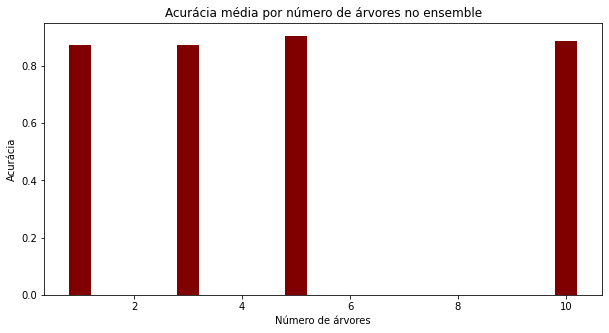

In [ ]:
n_trees = [1,3,5,10]
###OBS: valores numericos devem ser do tipo float64
wine_recognition = wine_recognition[wine_recognition.columns].astype(float)
display('[*] Wine Data Set [*]')
test_eval = tree_number_evaluation(data=wine_recognition, features=wine_recognition_predictive_attributes, target=target_attribute, n_trees=n_trees, n_fold=10, numerical_features=wine_recognition_predictive_attributes)

'[*] 1984 United States Congressional Voting [*]'

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,mean,std
Trees,,,,,,,,,,,,
1,1.000000,0.840909,0.931818,0.795455,0.954545,0.909091,0.954545,0.860465,0.904762,0.904762,0.905635,0.060330
3,0.954545,0.931818,0.954545,0.818182,0.977273,0.931818,0.977273,0.883721,0.833333,0.904762,0.916727,0.056318
5,0.977273,0.931818,0.931818,0.931818,0.977273,0.909091,0.954545,1.000000,0.785714,0.880952,0.928030,0.061105
10,0.977273,0.954545,0.886364,0.909091,0.977273,0.931818,0.977273,0.976744,0.809524,0.952381,0.935229,0.054343


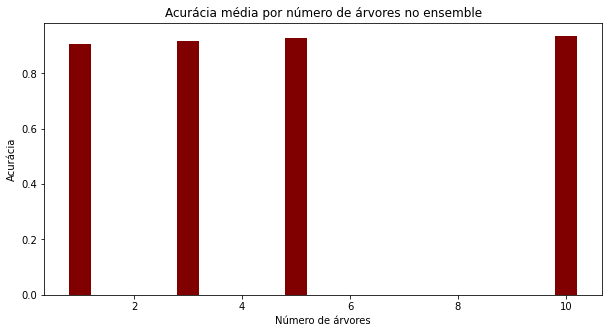

In [ ]:
display('[*] 1984 United States Congressional Voting [*]')
house_votes_eval = tree_number_evaluation(data=house_votes, features=house_votes_predictive_attributes, target=target_attribute, n_trees=n_trees, n_fold=10, numerical_features=[])